In [1]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


IntSlider(value=0, description='Sample:', max=20605200, step=60000)

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


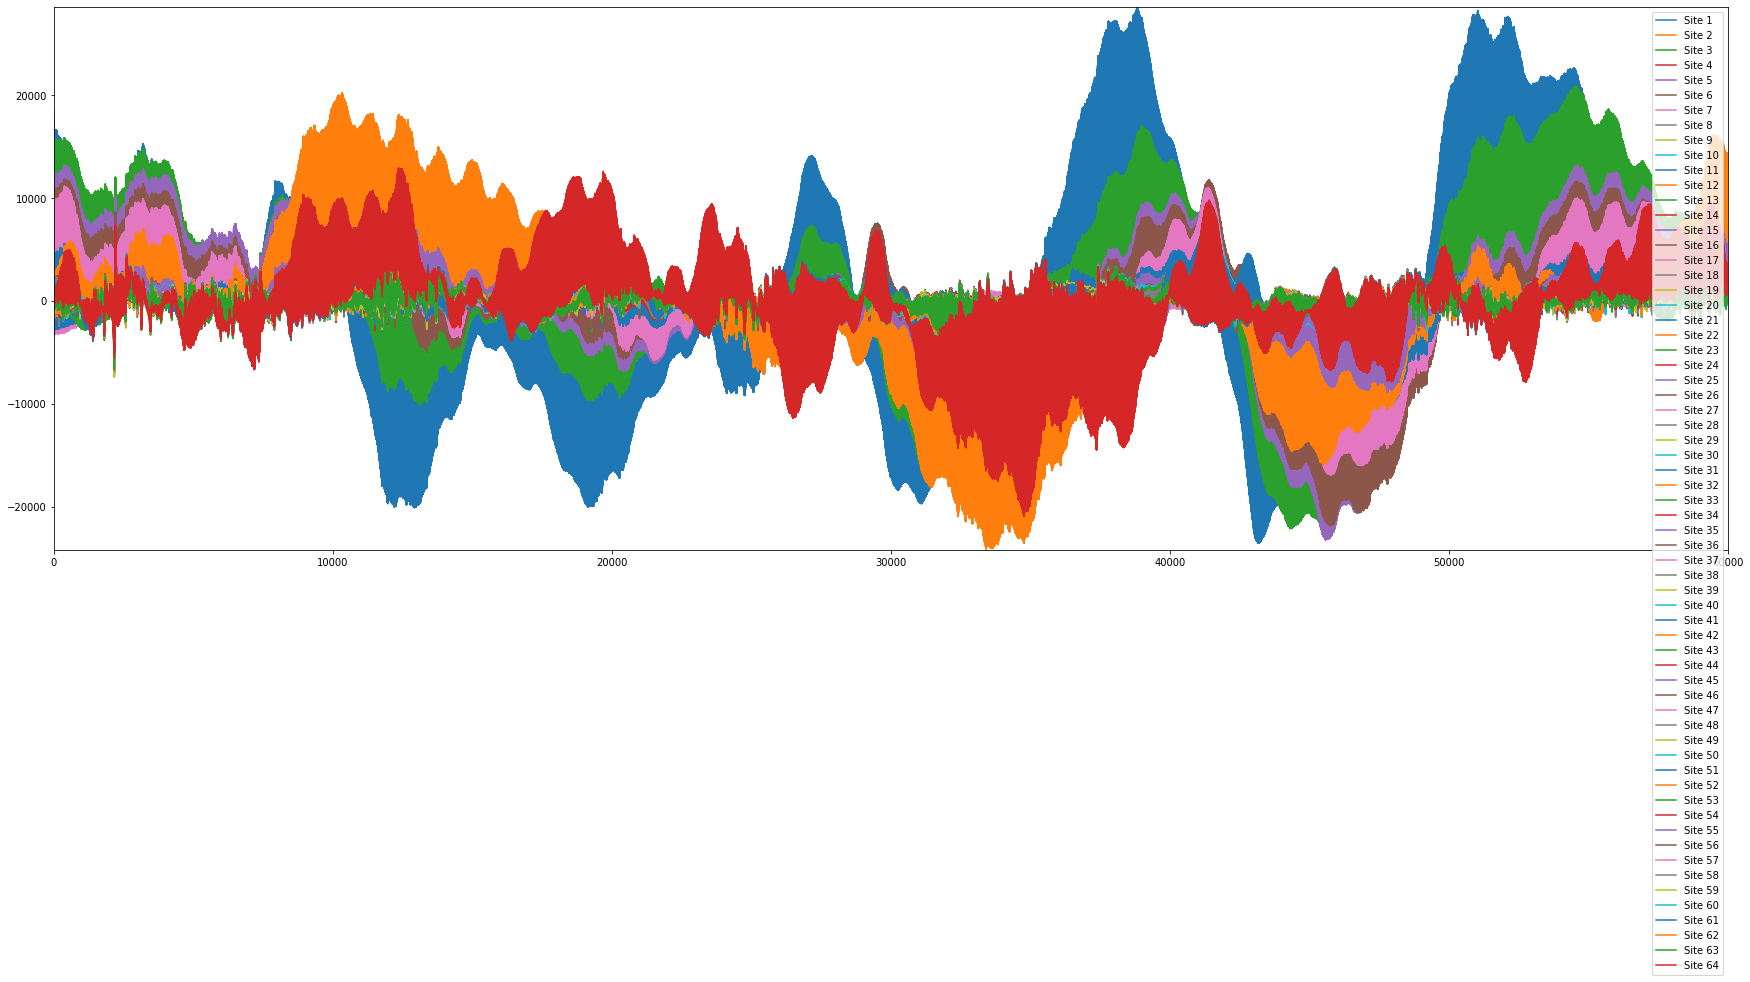

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


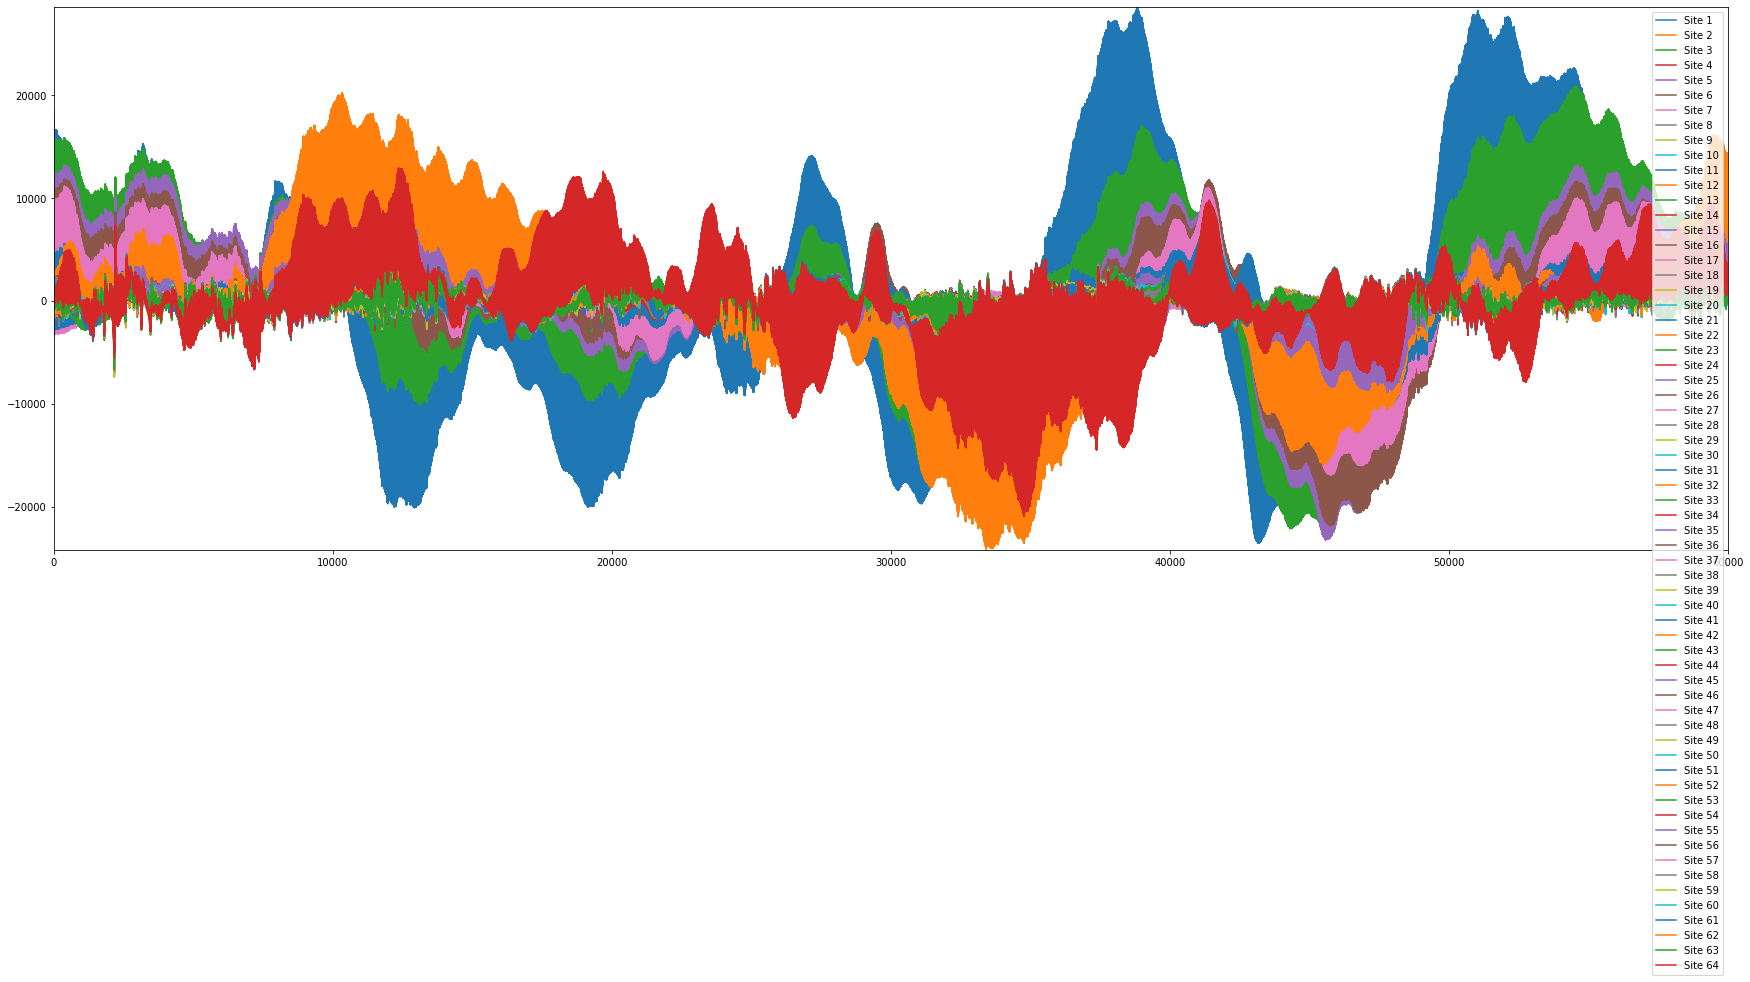

In [2]:
# Function to load data from .dat file
def load_data(file_path, num_channels):
    data = np.fromfile(file_path, dtype=np.int16)
    num_samples = len(data) // num_channels
    return data.reshape((num_samples, num_channels))

# Class to handle data plotting with interactive widget
class DataPlotter:
    def __init__(self, data, num_channels, window_size):
        self.data = data
        self.num_channels = num_channels
        self.window_size = window_size
        self.slider = widgets.IntSlider(min=0, max=len(data)-window_size, step=window_size, description='Sample:')
        self.slider.observe(self.update_plot, names='value')
        self.fig, self.ax = plt.subplots(figsize=(30, 10))
        self.offset = np.arange(self.num_channels) * 20000  # Create offsets for each site
        self.lines = [self.ax.plot(data[:window_size, i]+self.offset[i], label=f'Site {i+1}')[0] for i in range(num_channels)]
        self.ax.legend()
        self.update_plot({'new': 0})
        
    def update_plot(self, change):
        start = self.slider.value
        end = start + self.window_size
        for i, line in enumerate(self.lines):
            line.set_ydata(self.data[start:end, i])
        self.ax.set_xlim(0, self.window_size)
        self.ax.set_ylim(np.min(self.data[start:end, :]), np.max(self.data[start:end, :]))
        self.fig.canvas.draw()
        
    def display(self):
        display(self.slider)
        display(self.fig)

# Load data
file_path = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
num_channels = 64  # Number of recording sites
data = load_data(file_path, num_channels)

# Define window size for plotting (number of samples to display at once)
sampling_rate = 30000
seconds = 2
window_size = sampling_rate*seconds

# Initialize and display the plotter widget
plotter = DataPlotter(data, num_channels, window_size)
plotter.display()


In [3]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Function to load a specific chunk of data from the .dat file
def load_data_chunk(file_path, num_sites, start_sample, window_size):
    with open(file_path, 'rb') as f:
        # Calculate the byte offset for the start of the chunk
        byte_offset = start_sample * num_sites * 4  # 4 bytes per float32
        f.seek(byte_offset)
        # Read the required number of bytes for the window
        data_chunk = np.frombuffer(f.read(window_size * num_sites * 4), dtype=np.float32)
    return data_chunk.reshape((window_size, num_sites))

# Class to handle data plotting with interactive widget
class DataPlotter:
    def __init__(self, file_path, num_sites, window_size):
        self.file_path = file_path
        self.num_sites = num_sites
        self.window_size = window_size
        # Assume we know the total number of samples in advance
        self.total_samples = self.get_total_samples()
        self.slider = widgets.IntSlider(min=0, max=self.total_samples-window_size, step=1, description='Sample:')
        self.slider.observe(self.update_plot, names='value')
        
        self.fig, self.ax = plt.subplots(figsize=(15, 15))
        self.lines = [self.ax.plot(np.zeros(window_size), label=f'Site {i+1}')[0] for i in range(num_sites)]
        self.ax.legend()
        self.update_plot({'new': 0})
        
    def get_total_samples(self):
        # Calculate the total number of samples in the file
        with open(self.file_path, 'rb') as f:
            f.seek(0, 2)  # Move the cursor to the end of the file
            file_size = f.tell()
        return file_size // (self.num_sites * 4)  # Each sample has num_sites * 4 bytes (float32)
        
    def update_plot(self, change):
        start = self.slider.value
        data_chunk = load_data_chunk(self.file_path, self.num_sites, start, self.window_size)
        offset = np.arange(self.num_sites) * 10  # Create offsets for each site
        for i, line in enumerate(self.lines):
            line.set_ydata(data_chunk[:, i] + offset[i])
        self.ax.set_xlim(0, self.window_size)
        self.ax.set_ylim(np.min(data_chunk + offset[0]), np.max(data_chunk + offset[-1]))
        self.fig.canvas.draw()
        
    def display(self):
        display(self.slider)
        display(self.fig)

# Initialize and display the plotter widget
file_path = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
num_sites = 64  # Number of recording sites
sampling_rate = 30000
seconds = 2
window_size = sampling_rate*seconds
plotter = DataPlotter(file_path, num_sites, window_size)
plotter.display()


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in add
/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in add


ValueError: Axis limits cannot be NaN or Inf

Error in callback <function flush_figures at 0x7fd16199e1e0> (for post_execute):


KeyboardInterrupt: 

ValueError: cannot reshape array of size 32000 into shape (1000,64)

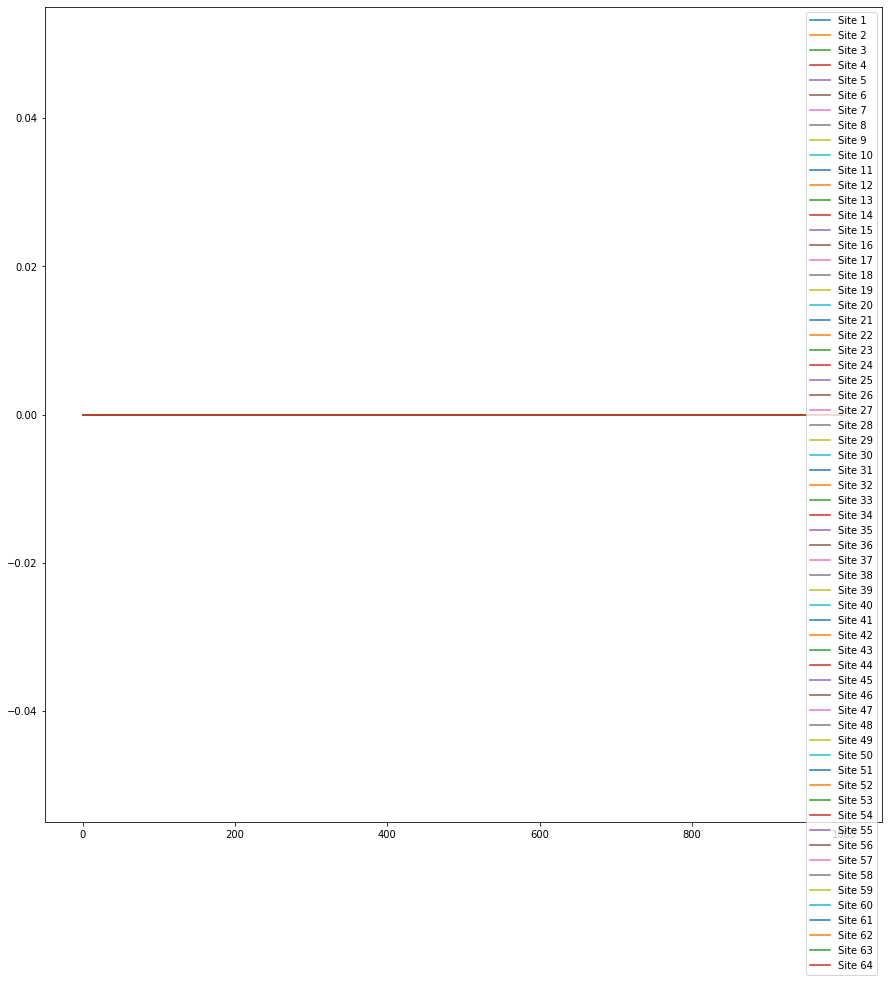

In [11]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Function to create a memory-mapped object for the .dat file
def create_memmap(file_path, num_sites):
    return np.memmap(file_path, dtype=np.int16, mode='r').reshape(-1, num_sites)

# Class to handle data plotting with interactive widget
class DataPlotter:
    def __init__(self, file_path, num_sites, window_size):
        self.file_path = file_path
        self.num_sites = num_sites
        self.window_size = window_size
        
        # Create a memory-mapped object
        self.data = create_memmap(file_path, num_sites)
        self.total_samples = self.data.shape[0]
        
        self.slider = widgets.IntSlider(min=0, max=self.total_samples-window_size, step=1, description='Sample:')
        self.slider.observe(self.update_plot, names='value')
        
        # Initialize the plot
        self.fig, self.ax = plt.subplots(figsize=(15, 15))
        self.lines = [self.ax.plot(np.zeros(window_size), label=f'Site {i+1}')[0] for i in range(num_sites)]
        self.ax.legend()
        self.display()  # Display the initial plot and slider
        
    def update_plot(self, change):
        start = self.slider.value
        end = start + self.window_size
        data_chunk = self.data[start:end, :]
        offset = np.arange(self.num_sites) * 1000  # Create offsets for each site (adjust as needed)
        for i, line in enumerate(self.lines):
            line.set_ydata(data_chunk[:, i] + offset[i])
        self.ax.set_xlim(0, self.window_size)
        self.ax.set_ylim(np.min(data_chunk + offset[0]), np.max(data_chunk + offset[-1]))
        self.fig.canvas.draw()
        
    def display(self):
        display(self.slider)
        display(self.fig)

# Initialize and display the plotter widget
file_path = 'path/to/your/data.dat'
num_sites = 64  # Number of recording sites
window_size = 1000  # Define window size for plotting

plotter = DataPlotter(file_path, num_sites, window_size)


In [14]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os

def MapLFPs(path, nch, dtype=np.int16 ,order='F'):
        '''Returns a 2D numpy <memmap>-object to a binary file, which is indexable as [channel, sample].

        INPUT:
        - [path]:              <str> containing full path to binary-file
        - [nch]:               <int> number of channels in binary file
        - [dtype]=np.int16:    <numpy-type> of binary data points'''

        ## Calculate the total number of data points in the provided binary-file
        size = os.path.getsize(path)
        size = int(size/np.dtype(dtype).itemsize)

        ## Create and return the 2D memory-map object
        memMap = np.memmap(path, mode='r', dtype=dtype, order=order, shape=(nch, int(size/nch)))

        return memMap

# Class to handle data plotting with interactive widget
class DataPlotter:
    def __init__(self, file_path, num_sites, window_size):
        self.file_path = file_path
        self.num_sites = num_sites
        self.window_size = window_size
        
        # Create a memory-mapped object
        self.data = MapLFPs(self.file_path, self.num_sites)
        self.total_samples = self.data.shape[0]
        
        self.slider = widgets.IntSlider(min=0, max=self.total_samples-window_size, step=1, description='Sample:')
        self.slider.observe(self.update_plot, names='value')
        
        # Initialize the plot
        self.fig, self.ax = plt.subplots(figsize=(15, 15))
        self.lines = [self.ax.plot(np.zeros(window_size), label=f'Site {i+1}')[0] for i in range(num_sites)]
        self.ax.legend()
        self.display()  # Display the initial plot and slider
        
    def update_plot(self, change):
        start = self.slider.value
        end = start + self.window_size
        data_chunk = self.data[start:end, :]
        offset = np.arange(self.num_sites) * 1000  # Create offsets for each site (adjust as needed)
        for i, line in enumerate(self.lines):
            line.set_ydata(data_chunk[:, i] + offset[i])
        self.ax.set_xlim(0, self.window_size)
        self.ax.set_ylim(np.min(data_chunk + offset[0]), np.max(data_chunk + offset[-1]))
        self.fig.canvas.draw()
        
    def display(self):
        display(self.slider)
        display(self.fig)

# Initialize and display the plotter widget
file_path = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
num_sites = 64  # Number of recording sites
window_size = 10000  # Define window size for plotting

plotter = DataPlotter(file_path, num_sites, window_size)


TraitError: setting max < min

In [15]:
def MapLFPs(path, nch, dtype=np.int16 ,order='F'):
        '''Returns a 2D numpy <memmap>-object to a binary file, which is indexable as [channel, sample].

        INPUT:
        - [path]:              <str> containing full path to binary-file
        - [nch]:               <int> number of channels in binary file
        - [dtype]=np.int16:    <numpy-type> of binary data points'''

        ## Calculate the total number of data points in the provided binary-file
        size = os.path.getsize(path)
        size = int(size/np.dtype(dtype).itemsize)

        ## Create and return the 2D memory-map object
        memMap = np.memmap(path, mode='r', dtype=dtype, order=order, shape=(nch, int(size/nch)))

        return memMap



In [21]:

shape = (num_channels, 30000) 
def update_plot(timepoint):
    plt.figure(figsize=(10, 6))
    plt.plot(LFPs[:, timepoint:timepoint+30000])  # Plot a window of 10 timepoints
    plt.title(f'Neural Activity from timepoint {timepoint} to {timepoint+9}')
    plt.xlabel('Neurons')
    plt.ylabel('Activity')
    plt.show()

time_slider = widgets.IntSlider(min=0, max=shape[1]-10, step=1, description='Timepoint')

# Update the plot when the slider value changes
widgets.interactive(update_plot, timepoint=time_slider)

# Display the slider
display(time_slider)


IntSlider(value=0, description='Timepoint', max=29990)

In [13]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os

def MapLFPs(path, nch, dtype=np.int16 ,order='F'):
        '''Returns a 2D numpy <memmap>-object to a binary file, which is indexable as [channel, sample].

        INPUT:
        - [path]:              <str> containing full path to binary-file
        - [nch]:               <int> number of channels in binary file
        - [dtype]=np.int16:    <numpy-type> of binary data points'''

        ## Calculate the total number of data points in the provided binary-file
        size = os.path.getsize(path)
        size = int(size/np.dtype(dtype).itemsize)

        ## Create and return the 2D memory-map object
        memMap = np.memmap(path, mode='r', dtype=dtype, order=order, shape=(nch, int(size/nch)))

        return memMap
        
def update_plot(start_seconds):
    plt.figure(figsize = (30,100))
    ax = plt.subplot(111)
    sr = 30000
    window_size = 2
    start = start_seconds*sr
    end = start+window_size*sr
    for i in range(num_channels):
        ax.plot(LFPs[i,start:end]+i*10000, c='gray')
    plt.show()


file_path = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
num_channels =128
LFPs = MapLFPs(file_path_128, num_channels, dtype=np.int16 ,order='F')
shape = list(LFPs.shape)
shape[1] = shape[1]//30000
time_slider = widgets.IntSlider(min=1, max=shape[1]-1, step=1, description='Timepoint')

# Update the plot when the slider value changes
widgets.interactive(update_plot, start_seconds=time_slider)

# Display the slider
display(time_slider)

IntSlider(value=1, description='Timepoint', max=343, min=1)

In [39]:
length = LFPs.shape[1//30000]
shape = list(LFPs.shape)
shape[1] = shape[1]//30000
print(shape)

[128, 344]


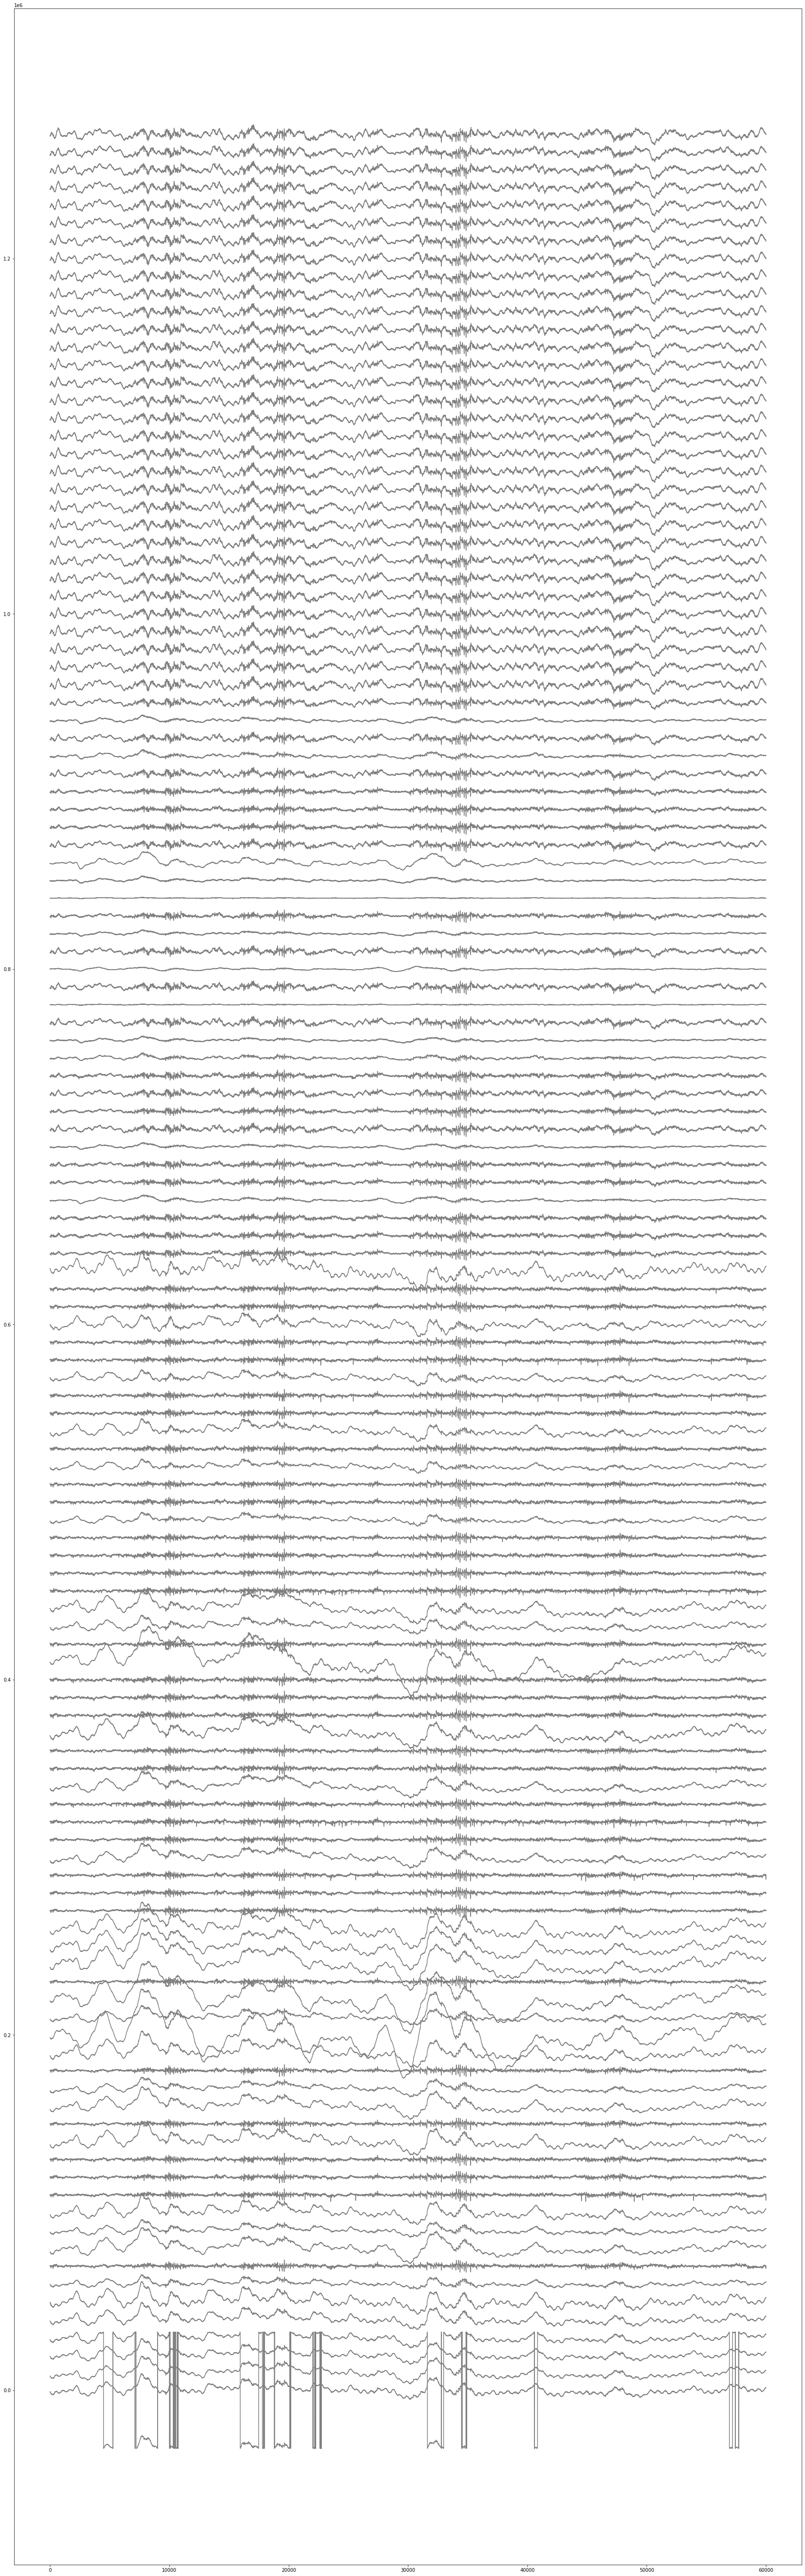

In [5]:

file_path_128 = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
file_path_64 = '/Users/AdamHarris/Desktop/2024-05-02_09-08-01/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'

num_channels =128
LFPs = MapLFPs(file_path_128, num_channels, dtype=np.int16 ,order='F')

fig, ax = plt.subplots(figsize = (30,100))
sr = 30000
start_seconds = 100
window_size = 2
start = start_seconds*sr
end = start+window_size*sr
for i in range(num_channels):
    ax.plot(LFPs[i,start:end]+i*10000, c='gray')
plt.savefig('/Users/AdamHarris/Desktop/128.jpg')
plt.show()

In [63]:
def update_plot(start_seconds):
    plt.figure(figsize=(30, 100))
    sr = 30000
    window_size = 2
    num_channels=128
    start = start_seconds*sampling_rate
    end = start+window_size*sr
    for i in range(num_channels):
        plt.plot(LFPs[i,start:end]+i*10000)
    plt.show()



file_path = '/Users/AdamHarris/Desktop/2024-04-03_18-42-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'
file_path_64 = '/Users/AdamHarris/Desktop/2024-05-02_09-08-01/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'

num_channels =128
LFPs = MapLFPs(file_path, num_channels, dtype=np.int16 ,order='F')
shape = list(LFPs.shape)
shape[1] = shape[1]//30000

time_slider = widgets.IntSlider(min=1, max=shape[1]-1, step=1, description='Timepoint')

# Update the plot when the slider value changes
widgets.interactive(update_plot, start_seconds=time_slider)

# Display the slider
display(time_slider)


IntSlider(value=1, description='Timepoint', max=343, min=1)

In [59]:
shape

[128, 344]

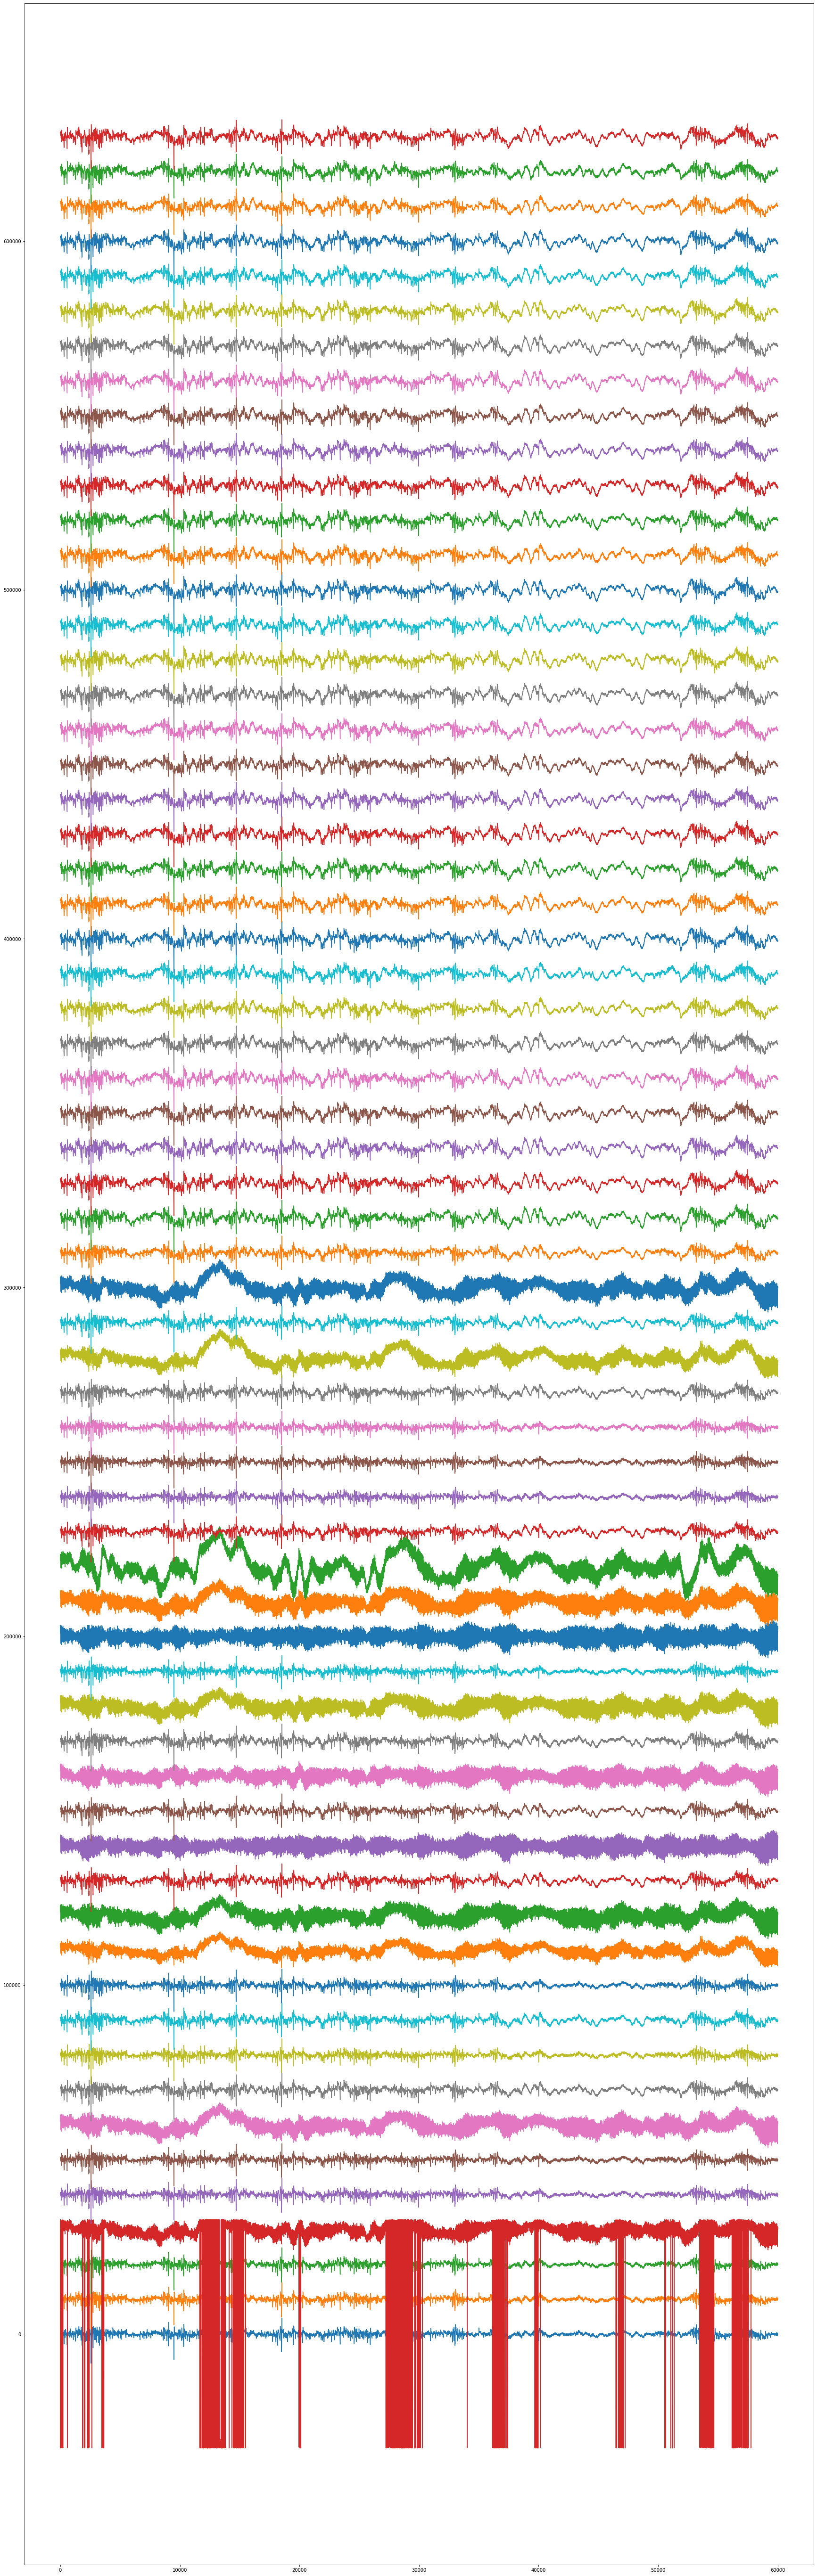

In [53]:

file_path_64 = '/Users/AdamHarris/Desktop/2024-05-02_09-08-01/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat'

num_channels =64
LFPs = MapLFPs(file_path_64, num_channels, dtype=np.int16 ,order='F')

fig, ax = plt.subplots(figsize = (30,100))
sr = 30000
start_seconds = 100
window_size = 2
start = start_seconds*sampling_rate
end = start+window_size*sr
for i in range(num_channels):
    ax.plot(LFPs[i,start:end]+i*10000)

plt.savefig('/Users/AdamHarris/Desktop/64.jpg')
plt.show()